In [37]:
import anndata
import scanpy
import desc

In [38]:
desc.run_desc_test()

Start to run a package test!
Start to process resolution= 0.1
The number of cpu in your computer is 8
Create the directory:result_tmp to save result
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Checking whether result_tmp/ae_weights.h5  exists in the directory
The file ae_weights.h5 is not exits
Pretraining the 1th layer...
learning rate = 0.1
Epoch 1/50
11/11 [==============================] - 0s 3ms/step - loss: 0.6674
Epoch 2/50
11/11 [==============================] - 0s 2ms/step - loss: 0.6157
Epoch 3/50
11/11 [==============================] - 0s 2ms/step - loss: 0.5709
Epoch 4/50
11/11 [==============================] - 0s 2ms/step - loss: 0.5417
Epoch 5/50
11/11 [==============================] - 0s 2ms/step - loss: 0.5210
Epoch 6/50
11/11 [==============================] - 0s 2ms/step - loss: 0.5040
Epoch 7/50
11/11 [==============================] - 0s 2ms/step

In [306]:
??desc.train

Signature:
desc.train(
    data,
    dims=None,
    alpha=1.0,
    tol=0.005,
    init='glorot_uniform',
    louvain_resolution=[0.6, 0.8],
    n_neighbors=10,
    pretrain_epochs=300,
    batch_size=256,
    activation='relu',
    actincenter='tanh',
    drop_rate_SAE=0.2,
    is_stacked=True,
    use_earlyStop=True,
    use_ae_weights=True,
    save_encoder_weights=False,
    save_encoder_step=5,
    save_dir='result_tmp',
    max_iter=1000,
    epochs_fit=5,
    num_Cores=20,
    num_Cores_tsne=10,
    use_GPU=False,
    GPU_id=None,
    random_seed=201809,
    verbose=True,
    do_tsne=False,
    learning_rate=150,
    perplexity=30,
    do_umap=False,
    kernel_clustering='t',
)
Docstring:
Deep Embeded single cell clustering(DESC) API
Conduct clustering for single cell data given in the anndata object or np.ndarray,sp.sparmatrix,or pandas.DataFrame
  

Argument:
------------------------------------------------------------------
data: :class:`~anndata.AnnData`, `np.ndarray`, `sp.s

### 0 Import python modules

In [39]:
import desc
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                                         9.2.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
asttokens                                   NA
astunparse                                  1.6.3
backcall                                    0.2.0
beta_ufunc                                  NA
binom_ufunc                                 NA
bottleneck                                  1.3.5
brotli                                      NA
certifi                                     2022.09.24
cffi                                        1.15.1
charset_normalizer                          2.1.0
colorama                                    0.4.5
cycler                                      0.10.0
cython_runtime                              NA
dateutil                                    2.8.2
debugpy                                     1.5.1
decorator                                   5.1.1
defusedxml      

### 1 Import data
The current version of desc works with an AnnData object. AnnData stores a data matrix .X together with annotations of observations .obs, variables .var and unstructured annotations .uns. The desc package provides 3 ways to prepare an AnnData object for the following analysis.

#### 1.1 Start from a 10X dataset
The desc package provides a function to load the 10X dataset directly. Download the data and unzip it. Then put everything in filtered_gene_bc_matrices/hg19/ to data/pbmc/.

In [3]:
# load the 10X data by providing the path of the data
adata = desc.read_10X(data_path='data/pbmc')

var_names are not unique, "make_index_unique" has applied


ValueError: AnnData expects .var.index.name to be a string or None, but you passed a name of type 'int64'

#### 1.2 Start from *.mtx and *.tsv files
When the expression data do not follow the standard 10X dataset format, we can manually import the data as follows.

In [242]:
adata = desc.tools.read.read_mtx('data/pbmc/mydata/matrix.mtx').T

In [243]:
adata

AnnData object with n_obs × n_vars = 996 × 43799

In [244]:
genes = pd.read_csv('data/pbmc/mydata/genes.tsv', header=None, sep='\t')
adata.var['gene_ids'] = genes[0].values
adata.var['gene_symbols'] = genes[1].values
adata.var_names = adata.var['gene_symbols']
# Make sure the gene names are unique
adata.var_names_make_unique(join="-")

In [245]:
cells = pd.read_csv('data/pbmc/mydata/barcodes.tsv', header=None, sep='\t')
adata.obs['barcode'] = cells[0].values
adata.obs_names = cells[0]
# Make sure the cell names are unique
adata.obs_names_make_unique(join="-")

### 2 Preprocessing
The standard scRNA-seq data preprocessing workflow includes filtering of cells/genes, normalization, scaling and selection of highly variables genes. In this tutorial, we use scanpy to preprocess the data. Note that among the preprocessing steps, filtration of cells/genes and selecting highly variable genes are optional, but normalization and scaling are strictly required before the desc analysis.

The following steps show a typical preprocessing procedure for analyzing the PBMC data.

#### 2.1 Filtering cells and genes
Typing adata in the python console shows that the original dataset contains expression values for 2700 cells across 32738 genes.

In [246]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [247]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

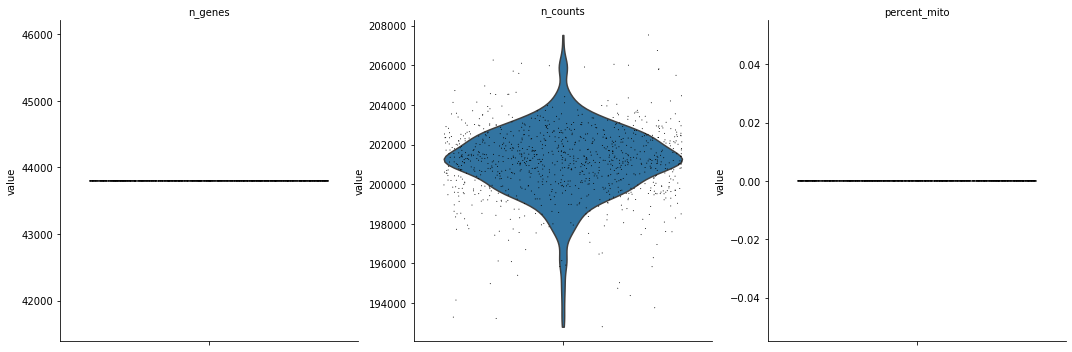

In [248]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True)

In [249]:
# adata = adata[adata.obs['n_genes'] < 2500, :]
# adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [250]:
adata

AnnData object with n_obs × n_vars = 996 × 43799
    obs: 'barcode', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'gene_symbols', 'n_cells'

#### 2.2 Normalization
The function normalize_per_cell normalizes each cell by total counts of all genes, so that every cell has the same total count after normalization (10,000 by default).

In [251]:
desc.normalize_per_cell(adata, counts_per_cell_after=1e4)
#or use
#sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


#### 2.3 Logarithm transformation
Also, the following analysis and the desc analysis should be performed on the log-scaled data.

In [252]:
desc.log1p(adata)
#or use
#sc.pp.log1p(adata)

Set the .raw attribute of AnnData object to the logarithmized raw gene expression for downstream analysis, such as differential expression analysis, and pseudotime analysis . This simply freezes the state of the current AnnData object.

In [253]:
adata.raw=adata

#### 2.4 Selection of highly variable genes
We recommend performing desc analysis on highly variable genes, which can be selected using highly_variable_genes function. It takes normalized, log-scaled data as input and can provide an AnnData object which contains a subset of highly variable genes.

The function is from scanpy. Check the function document for detailed information about the usage and the parameter setting.

In [254]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=True)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [255]:
adata = adata[:, adata.var['highly_variable']]

Note:The function sc.pp.highly_variable_genes is slightly different from sc.pp.filter_genes_dispersion. The function sc.pp.highly_variable_genes is similar to FindVariableGenes in R package Seurat and it only adds some information to adata.var, but cannot filter an AnnData object automatically. Thus, if using the function sc.pp.filter_genes_dispersion , you must make sure using it after sc.pp.filter_genes_dispersion but before sc.pp.log1p.

In this dataset, 1838 genes are kept as highly variable genes.

In [256]:
adata

View of AnnData object with n_obs × n_vars = 996 × 14476
    obs: 'barcode', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'gene_symbols', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

#### 2.4 Scaling
Finally, the data need to be standardized before the desc analysis.

In [257]:
desc.scale(adata, zero_center=True, max_value=3)
#or use
#sc.pp.scale(adata, zero_center=True, max_value=3)

/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


### 3 Desc analysis
With the above data preprocessing, we are ready to run a desc analysis. The function train will perform desc on the expression matrix (2638 × 1838 in this example) and save the clustering labels as well as other related results in the AnnData object. For a full list of desc parameters please check the desc documentation on the pypi.

In [258]:
adata = desc.train(adata, dims=[adata.shape[1], 32, 16], tol=0.005, n_neighbors=10,
                   batch_size=256, louvain_resolution=[0.8],
                   save_dir="result_pbmc3k", do_tsne=True, learning_rate=300,
                   do_umap=True, num_Cores_tsne=4,
                   save_encoder_weights=True)

Start to process resolution= 0.8
The number of cpu in your computer is 8
Create the directory:result_pbmc3k to save result
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Checking whether result_pbmc3k/ae_weights.h5  exists in the directory
The file ae_weights.h5 is not exits
Pretraining the 1th layer...
learning rate = 0.1
Epoch 1/50
4/4 [==============================] - 0s 32ms/step - loss: 0.8007
Epoch 2/50
4/4 [==============================] - 0s 29ms/step - loss: 0.8004
Epoch 3/50
4/4 [==============================] - 0s 29ms/step - loss: 0.8000
Epoch 4/50
4/4 [==============================] - 0s 28ms/step - loss: 0.7995
Epoch 5/50
4/4 [==============================] - 0s 28ms/step - loss: 0.7994
Epoch 6/50
4/4 [==============================] - 0s 27ms/step - loss: 0.7993
Epoch 7/50
4/4 [==============================] - 0s 28ms/step - loss: 0.7989
Epoch 8/50
4/4

/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/scanpy/tools/_tsne.py:113: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  warnings.warn(
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:02)
tsne finished and added X_tsne0.8  into the umap coordinates (adata.obsm)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
umap finished and added X_umap0.8  into the umap coordinates (adata.obsm)

The run time for all resolution is: 41.30642867088318
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 996 × 14476
    obs: 'barcode', 'n_genes', 'percent_mito', 'n_counts', 'desc_0.8'
    var: 'gene_ids', 'gene_symbols', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'tsne', 'umap', 'prob_matrix0.8'
    obsm: 'X_Embeded_z0.8', 'X_tsne', 'X_tsne0.8', 'X_umap', 'X_umap0.8'
    obsp: 'distance

After training of the desc model, several result slots will be added to the adata.

The following results are based on desc under resolution=0.8.

The clustering result desc_0.8 has been added to adata.obs, which include clustering labels from desc.
The tSNE coordinate X_tsne0.8 has been added to adata.obsm.
The Umap coordinate X_umap0.8 has been added to adata.obsm.
The maximum probability matrix prob_matrix0.8 has been added to adata.uns.
X_Embeded_z0.8 is the low dimensional representation of the expression data, the size is the number of cells by the number of network nodes in the bottleneck layer (2638 x 16 in this tutorial). This slot facilitates users to generate tSNE or Umap plot or do other downstream analysis.


### 4 Visualization
Here, we want to check the clustering results, max probabilities, and feature plots based on the tSNE and Umap.

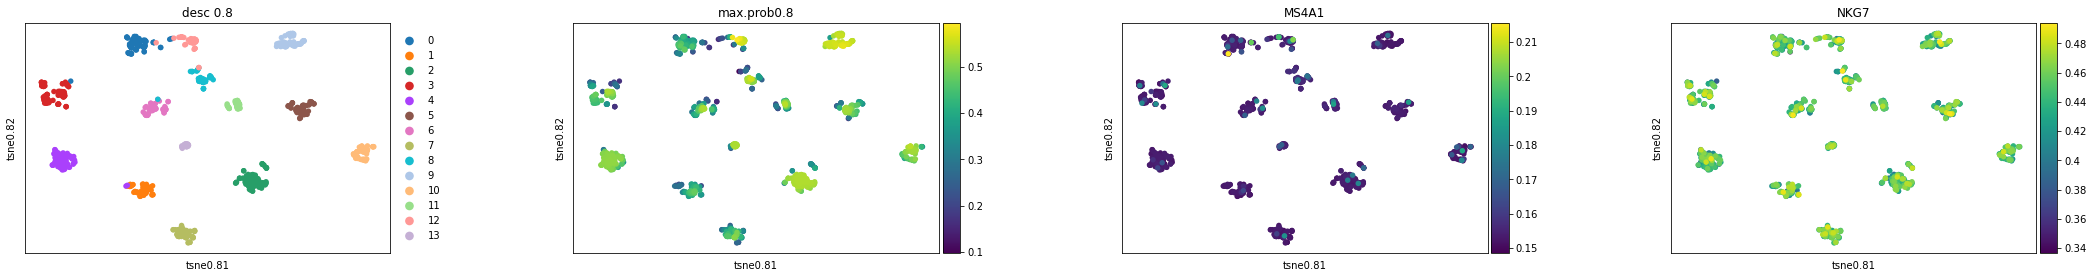

In [259]:
prob_08=adata.uns["prob_matrix0.8"]
adata.obs["max.prob0.8"]=np.max(prob_08,axis=1)
#tSNE plot 
sc.pl.scatter(adata,basis="tsne0.8",color=['desc_0.8',"max.prob0.8",'MS4A1', 'NKG7'])

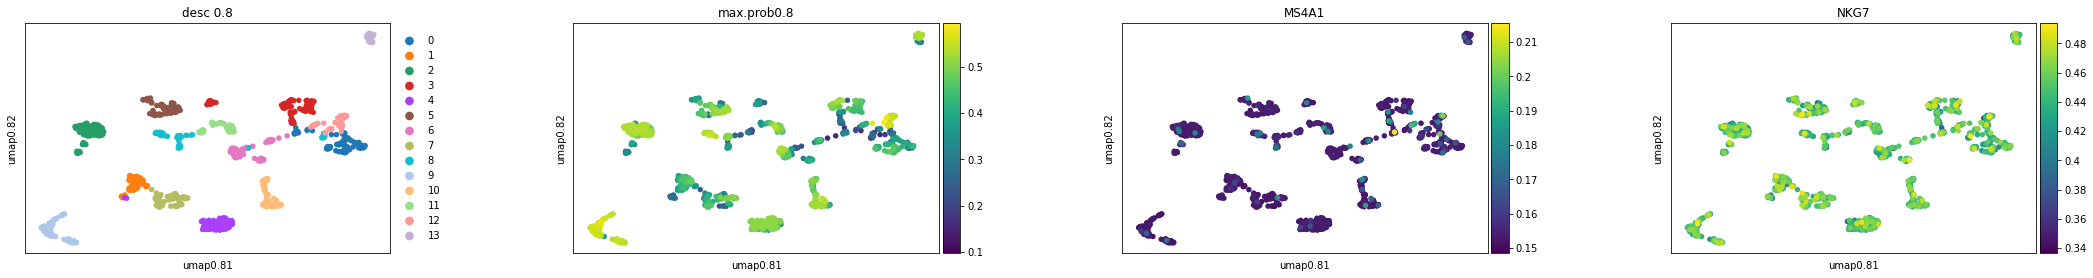

In [260]:
#Umap plot 
sc.pl.scatter(adata,basis="umap0.8",color=['desc_0.8',"max.prob0.8",'MS4A1', 'NKG7'])

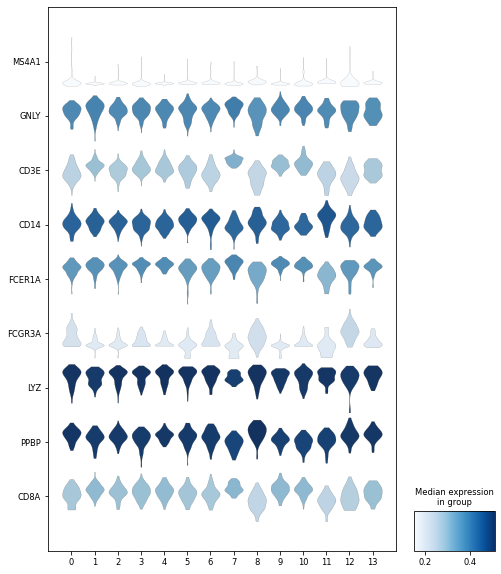

In [261]:
adata.obs["desc_0.8"]=adata.obs["desc_0.8"].astype(str)
sc.pl.stacked_violin(adata, ["MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"],
                     groupby='desc_0.8',figsize=(8,10),swap_axes=True)

Note: If you want to how to extract some information from an AnnData in R, Please click here

### 5 Save the result
Save the desc results for future analysis.

#### 5.1 Save to a *.h5ad file
The AnnData object can be saved to a *.h5ad file for the further analysis in a Python environment.

In [263]:
adata.write('result/desc_result.h5ad')

#### 5.2 Save to *.csv files
Also, the desc result can be separatly saved to *.csv files, which can be easily accessed using R, C or other tools for the future analysis.

In [264]:
#`obs` slot
meta_data=adata.obs.copy()
meta_data.to_csv("meta.data.csv",sep=",")
#`obsm` slot, which is numpy.ndarray
obsm_data=pd.DataFrame(adata.obsm["X_tsne0.8"])
obsm_data.to_csv("tsne.csv",sep=",")

In [268]:
adata

AnnData object with n_obs × n_vars = 996 × 14476
    obs: 'barcode', 'n_genes', 'percent_mito', 'n_counts', 'desc_0.8', 'max.prob0.8'
    var: 'gene_ids', 'gene_symbols', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'tsne', 'umap', 'prob_matrix0.8', 'desc_0.8_colors'
    obsm: 'X_Embeded_z0.8', 'X_tsne', 'X_tsne0.8', 'X_umap', 'X_umap0.8'
    obsp: 'distances', 'connectivities'

### my data

In [202]:
from shutil import copyfile
import csv
import scipy.sparse as sparse
import scipy.io as sio
import scipy.stats as stats
import numpy as np

In [203]:
def write_to_tsv(output_path: str, file_columns: list, data: list):
    csv.register_dialect('tsv_dialect', delimiter='\t', quoting=csv.QUOTE_ALL)
    with open(output_path, "w", newline="") as wf:
        writer = csv.DictWriter(wf, fieldnames=file_columns, dialect='tsv_dialect')
        writer.writerows(data)
    csv.unregister_dialect('tsv_dialect')

def read_from_tsv(file_path: str, column_names: list) -> list:
    csv.register_dialect('tsv_dialect', delimiter='\t', quoting=csv.QUOTE_ALL)
    with open(file_path, "r") as wf:
        reader = csv.DictReader(wf, fieldnames=column_names, dialect='tsv_dialect')
        datas = []
        for row in reader:
            data = dict(row)
            datas.append(data)
    csv.unregister_dialect('tsv_dialect')
    return datas

In [204]:
copyfile('/data/users/machiyu/python_nbs/Project/df-based-biomarker-miner/upload_file/geo/SLE/GSE65391.csv','./data/pbmc/GSE65391.csv')

'./data/pbmc/GSE65391.csv'

In [205]:
rawdata = pd.read_csv('data/pbmc/mydata/GSE65391.csv',index_col = 0)

/tmp/ipykernel_39432/1505067580.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

In [206]:
rawdata = rawdata.drop('pred')

In [207]:
barcodes_col1name = 'sample id'
genes_col1name = 'gene number'
genes_col2name = 'gene symbol'
mtx_col1name = 'generaw'
mtx_col2name = 'sampleraw'
mtx_col3name = 'geneexp'

In [208]:
barcodes = pd.DataFrame(data={barcodes_col1name:rawdata.columns})

In [210]:
barcodes_dict = [{barcodes_col1name:barcodes.loc[i,barcodes_col1name]} for i in barcodes.index]

In [211]:
genes = pd.DataFrame(data={genes_col1name:range(1,len(rawdata.index)+1),genes_col2name:rawdata.index})

In [219]:
genes_dict = [{genes_col1name:genes.loc[i,genes_col1name],genes_col2name:genes.loc[i,genes_col2name]} for i in genes.index]

In [220]:
write_to_tsv('./data/pbmc/mydata/genes.tsv',[genes_col1name,genes_col2name],genes_dict)

In [215]:
write_to_tsv('./data/pbmc/mydata/barcodes.tsv',[barcodes_col1name],barcodes_dict)

In [216]:
raw_csrmtx = sparse.csr_matrix(rawdata.values.astype('float64'))

In [217]:
raw_csrmtx.todense()
raw_csrmtx.toarray()

array([[13.7800184 , 13.6121461 , 14.0425415 , ..., 13.8678569 ,
        13.9952107 , 13.5150185 ],
       [11.0813957 , 10.1860981 , 10.3400396 , ..., 11.5211042 ,
        11.1493458 , 10.1706825 ],
       [ 3.32192809,  3.32192809,  3.32192809, ...,  3.32192809,
         3.32192809,  3.32192809],
       ...,
       [ 3.32192809,  3.32192809,  3.32192809, ...,  3.32192809,
         3.32192809,  3.32192809],
       [ 3.32192809,  3.32192809,  3.32192809, ...,  3.32192809,
         3.32192809,  3.32192809],
       [ 4.07627432,  4.07627432,  4.07627432, ...,  4.60793272,
         3.32192809,  5.07964009]])

In [218]:
sio.mmwrite("./data/pbmc/mydata/matrix.mtx",raw_csrmtx)

In [269]:
result = desc.read_h5ad('./result/desc_result.h5ad')

/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/data/users/machiyu/anaconda3/envs/Flask/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [271]:
result.obs

,barcode,n_genes,percent_mito,n_counts,desc_0.8,max.prob0.8
GSM1594219,GSM1594219,43799,0.0,201846.906250,7,0.241310
GSM1594220,GSM1594220,43799,0.0,200742.187500,1,0.471570
GSM1594221,GSM1594221,43799,0.0,200416.296875,4,0.507265
GSM1594222,GSM1594222,43799,0.0,201139.828125,4,0.505018
GSM1594223,GSM1594223,43799,0.0,204108.125000,9,0.534927
...,...,...,...,...,...,...
GSM1595218,GSM1595218,43799,0.0,201492.609375,5,0.523126
GSM1595219,GSM1595219,43799,0.0,195845.625000,1,0.411790
GSM1595220,GSM1595220,43799,0.0,201635.687500,7,0.228301
GSM1595221,GSM1595221,43799,0.0,199680.265625,11,0.350344


In [305]:
adata.var_names

Index(['DUSP22', 'LOC642820', 'RPS28', 'LOC653113', 'CDT1', 'FLJ36848',
       'LOC645349', 'LOC389669', 'COL17A1', 'LOC339760',
       ...
       'MIR219-2', 'MIR33B', 'MIR1915', 'MIR490', 'SNORD114-2', 'FOXO6-1',
       'BEYLA-2', 'NCRNA00173', 'SKCG-1-2', 'NCRNA00173-1'],
      dtype='object', name='gene_symbols', length=14476)

In [309]:
??adata.chunk_X


Signature:
adata.chunk_X(
    select: Union[int, Sequence[int], numpy.ndarray] = 1000,
    replace: bool = True,
)
Source:   
    def chunk_X(
        self,
        select: Union[int, Sequence[int], np.ndarray] = 1000,
        replace: bool = True,
    ):
        """\
        Return a chunk of the data matrix :attr:`X` with random or specified indices.

        Parameters
        ----------
        select
            Depending on the type:

            :class:`int`
                A random chunk with `select` rows will be returned.
            :term:`sequence` (e.g. a list, tuple or numpy array) of :class:`int`
                A chunk with these indices will be returned.

        replace
            If `select` is an integer then `True` means random sampling of
            indices with replacement, `False` without replacement.
        """
        if isinstance(select, int):
            select = select if select < self.n_obs else self.n_obs
            choice = np.random.choice(self.n_o

In [ ]:
desc.models.desc.AnnData.